In [130]:
import numpy as np
import suite2p as s2p
import suite2p_processing as s2p_pp
import PlittGiocomo_CA1Morph_2019 as utils
import matplotlib.pyplot as plt
import os
import scipy as sp
import sklearn as skl
from sklearn.linear_model import LinearRegression as linreg

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
datadir = "E:\\2P_Data\\VTA1\\12_03_2020\\VTA_SingleScene\\VTA_SingleScene_001_011\\suite2p\\plane0\\"
matfile = "E:\\2P_Data\\VTA1\\12_03_2020\\VTA_SingleScene\\VTA_SingleScene_001_011.mat"
vrdata = "D:\\VR_Data\\TwoTower\\VTA1\\12_03_2020\\VTA_SingleScene_1.sqlite"
saveprefix = "VTA1_16_03_2020_SingleScene_001_011"

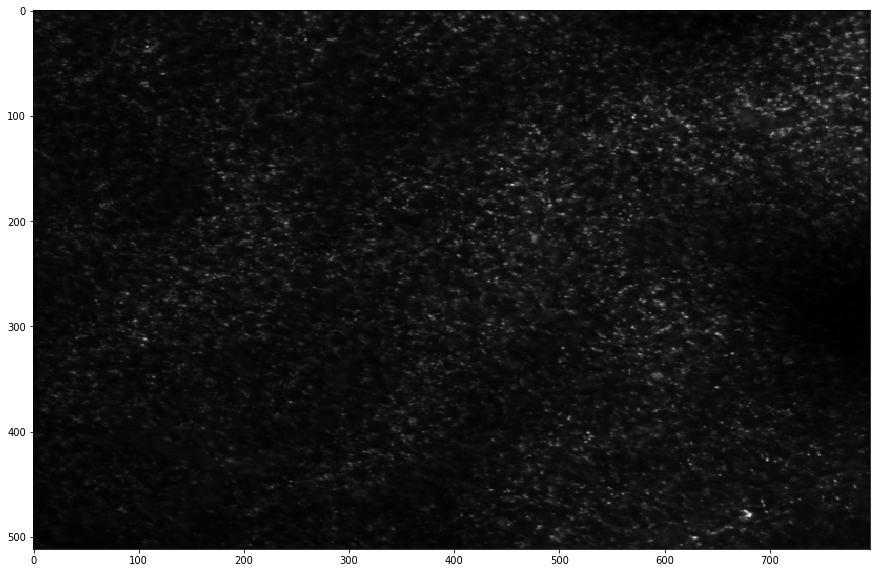

In [96]:
ops = np.load(os.path.join(datadir,"ops.npy"),allow_pickle=True).item()
info = utils.preprocessing.loadmat_sbx(matfile)

f,ax = plt.subplots(figsize=[15,15])
ax.imshow(ops['meanImg'],cmap='Greys_r')
# f.savefig()

In [97]:
VRDat = utils.preprocessing._VR_align_to_2P(utils.preprocessing._get_frame(vrdata,fix_teleports=True),matfile)


num aberrant ttls 0.0
8.707554320363819 1832.8312278928752
8.73168266801415 1832.7478524507328


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [98]:
print(VRDat.columns,VRDat.shape)

Index(['time', 'morph', 'trialnum', 'pos', 'dz', 'lick', 'reward', 'tstart',
       'teleport', 'rzone', 'toutzone', 'clickOn', 'blockWalls', 'towerJitter',
       'wallJitter', 'bckgndJitter', 'scanning', 'manrewards', 'cmd', 'speed',
       'lick rate'],
      dtype='object') (28337, 21)


In [99]:
print(info['max_idx'],np.arange(0,info['max_idx'],1000))
timesteps = np.arange(0,info['max_idx'],1000)

rowstep,colstep = 20, int(np.floor(20*796./512.))
bin_mov = np.zeros((info['max_idx'],int(np.floor(np.diff(ops['yrange'])/rowstep)),int(np.floor(np.diff(ops['xrange'])/colstep))))


for t in timesteps.tolist():
    print(t)
    start,stop =t,np.minimum(t+1000,info['max_idx'])
    mov = s2p.utils.get_frames(ops,np.arange(start,stop),os.path.join(datadir,"data.bin")).astype(np.float)
    
    mov = mov[:,ops['yrange'][0]:ops['yrange'][1],ops['xrange'][0]:ops['xrange'][1]]
    
    
    for row_i, (row_start,row_stop) in enumerate(zip(range(0,mov.shape[1]+1-rowstep,rowstep),range(rowstep,mov.shape[1]+1,rowstep))):
        for col_i, (col_start,col_stop) in enumerate(zip(range(0,mov.shape[2]+1-colstep,colstep),range(colstep,mov.shape[2]+1,colstep))):
            bin_mov[start:stop,row_i,col_i] = mov[:,row_start:row_stop,col_start:col_stop].mean(axis=1,keepdims=True).mean(axis=2,keepdims=True).ravel()
    

28337 [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000]
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [136]:
bin_mov_f = bin_mov.reshape([bin_mov.shape[0],-1])
print(bin_mov_f.shape)
model = linreg().fit(bin_mov_f.mean(axis=1,keepdims=True),bin_mov_f)
bin_mov_f -= model.predict(bin_mov_f.mean(axis=1,keepdims=True))
bin_mov_dff = utils.utilities.dff(bin_mov_f)
meansignal=bin_mov_dff.mean(axis=1)

(28337, 506)
(28337, 506)


Text(0, 0.5, 'ROI')

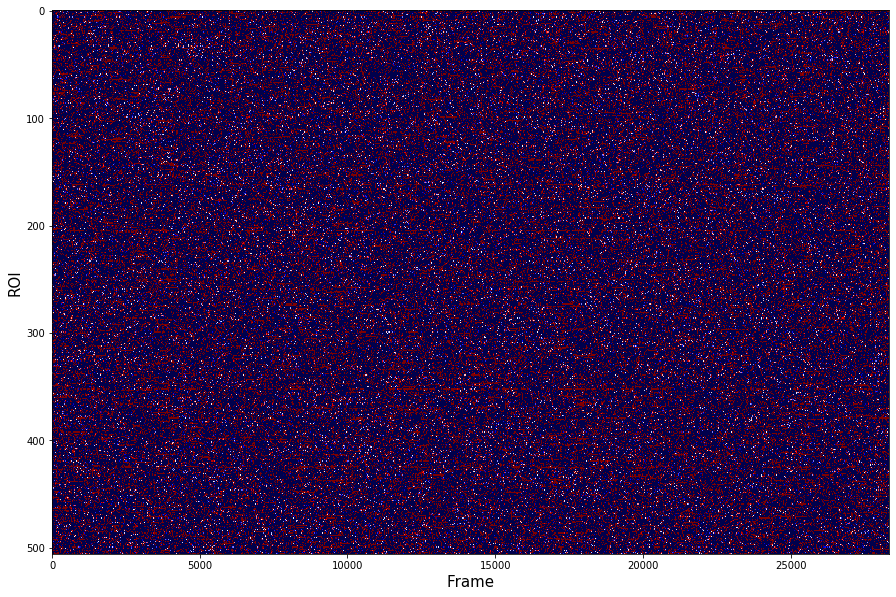

In [137]:
f,ax = plt.subplots(figsize=[15,10])
ax.imshow(bin_mov_dff.T,aspect='auto',cmap='seismic',vmin=-.2,vmax=.2)
ax.set_xlabel("Frame",fontsize=15)
ax.set_ylabel("ROI",fontsize=15)
# f.savefig("E:\\InVivoDA_results\\VTA1_12_03_2020_SingleScene_001_011_dffVTime.png")

In [138]:
meansignal=bin_mov_dff.mean(axis=1)

In [139]:
trial_info,tstart_inds,teleport_inds = utils.utilities.by_trial_info(VRDat)


In [140]:
print(VRDat.shape,meansignal.shape)

(28337, 21) (28337,)


Text(0.5, 1.0, 'Licks')

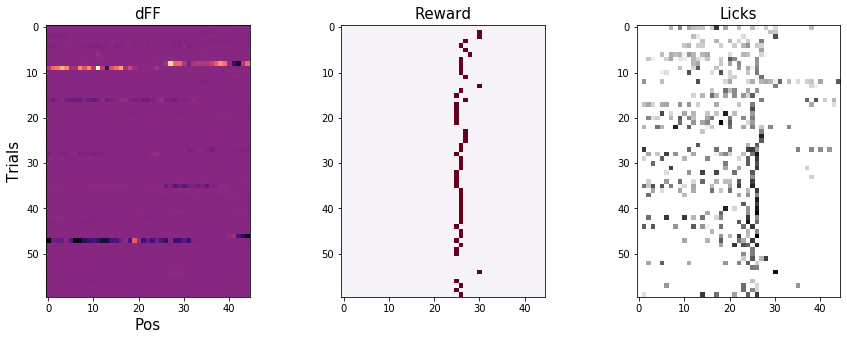

In [141]:
trial_mat,occ_mat,bin_edges,bin_centers = utils.utilities.make_pos_bin_trial_matrices(meansignal[:,np.newaxis],VRDat['pos']._values,tstart_inds,teleport_inds,bin_size=10)

reward_mat = utils.utilities.make_pos_bin_trial_matrices(VRDat['reward']._values[:,np.newaxis],VRDat['pos']._values,tstart_inds,teleport_inds,mat_only=True)

lick_mat = utils.utilities.make_pos_bin_trial_matrices(VRDat['lick']._values[:,np.newaxis],VRDat['pos']._values,tstart_inds,teleport_inds,mat_only=True)

f,ax = plt.subplots(1,3,figsize=[15,5])
ax[0].imshow(trial_mat,cmap='magma')
ax[0].set_xlabel("Pos",fontsize=15)
ax[0].set_ylabel("Trials",fontsize=15)
ax[0].set_title("dFF",fontsize=15)
ax[1].imshow(reward_mat>0,cmap='PuRd')
ax[1].set_title("Reward",fontsize=15)
ax[2].imshow(lick_mat,cmap="Greys")
ax[2].set_title("Licks",fontsize=15)

# f.savefig("E:\\InVivoDA_results\\VTA1_12_03_2020_SingleScene_001_011_posbinned.png")

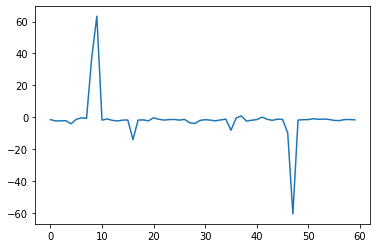

In [142]:
f,ax = plt.subplots()
ax.plot(trial_mat.mean(axis=1))

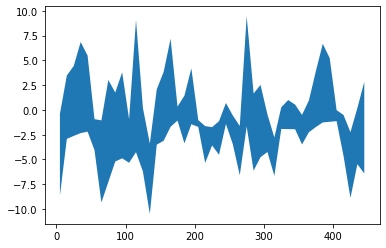

In [143]:
f,ax = plt.subplots()
mu,sem = trial_mat.mean(axis=0),sp.stats.sem(trial_mat,axis=0)
ax.fill_between(bin_centers,mu-sem,mu+sem)

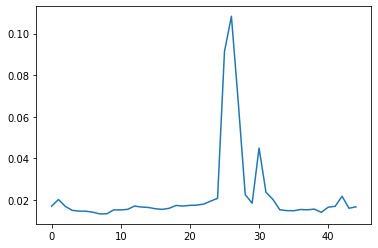

In [144]:
f,ax = plt.subplots()
ax.plot(occ_mat.mean(axis=0))

In [145]:
print(utils.UnityTransforms.xfreq(trial_info['morphs']+trial_info['wallJitter']))

[5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458
 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458 5.62141458]
